In [276]:
from bs4 import BeautifulSoup
from selenium import webdriver
import lxml
import numpy as np
import pandas as pd
import urllib.request
import ssl
import time
import openpyxl
import json
import requests
import matplotlib.pyplot as plt
from matplotlib import rc
import folium
from haversine import haversine
import seaborn as sns

plt.rcParams["axes.unicode_minus"] = False
rc("font", family = "Arial Unicode MS")
# %matplotlib inline : 실행을 했을 때 그래프가 바로 나타나게 하는 옵션
get_ipython().run_line_magic("matplotlib","inline")

# 00. 주소 > 좌표 변환 
- VWorld API KEY : "E418B8C2-CFEB-3549-9B61-9EEF8D1CDEA8"

In [3]:
def getCoord(address):
    try:
        req = requests.get("http://apis.vworld.kr/new2coord.do?q="+address+"&output=json&epsg=epsg:4326&apiKey=E418B8C2-CFEB-3549-9B61-9EEF8D1CDEA8")
        req_json = req.json()
        lat = req_json["EPSG_4326_Y"]
        lng = req_json["EPSG_4326_X"]
    except KeyError as ke:
        return {"lat": 0, "lng": 0}
    except TypeError as te:
        return {"lat": 0, "lng": 0}

    return {"lat": lat, "lng": lng}

# 1번 문제 : 스타벅스 매장, 주소, 구 DataFrame 만들기

In [4]:
#스타벅스 URL 입력
driver = webdriver.Chrome("../driver/chromedriver")
driver.get("https://www.starbucks.co.kr/store/store_map.do?disp=locale")

In [5]:
# 주소 탭 클릭
loca = driver.find_element_by_class_name("loca_search")
loca.click()
time.sleep(0.5)

In [6]:
#시도에서 "서울" 선택
sido = driver.find_element_by_class_name("sido_arae_box")
lisido = sido.find_elements_by_tag_name("li")
lisido[0].click()

#for obj in lisido:
#    if obj.text == "서울":
#        obj.click()
#        break

time.sleep(0.5)

In [7]:
# 04. "구" 전체 선택
gugun = driver.find_element_by_class_name("gugun_arae_box")
ligugun = gugun.find_elements_by_tag_name("li")
ligugun[0].click()
time.sleep(3)

In [8]:
# 05. 페이지 소스 받아오기
source = driver.page_source

In [9]:
# 06. ul > li 요소 분석하여 받아오기
bs = BeautifulSoup(source, 'lxml')
entire = bs.find('ul', class_='quickSearchResultBoxSidoGugun')
starbucks_list = entire.find_all('li')
print("매장 수 : ", len(starbucks_list))

매장 수 :  566


In [27]:
# 07. DataFrame 형태로 변환하기 & "구군" 목록 저장하기(이디야에서 사용)
df_starbucks = pd.DataFrame(columns=["매장명", "주소", "구군", "위도", "경도"])
list_gugun = []

In [28]:
for stores in starbucks_list:
    store_dict = {
        "매장명": stores.find('strong').text,
        "주소": stores.find('p').text,
        "구군": stores.find('p').text.split(" ")[1],
        "위도": stores['data-lat'],
        "경도": stores['data-long']
    }
    df_starbucks = df_starbucks.append(store_dict, ignore_index=True)
    list_gugun.append(stores.find('p').text.split(" ")[1])

In [29]:
print(df_starbucks.head())

         매장명                                   주소   구군         위도          경도
0  역삼아레나빌딩       서울특별시 강남구 언주로 425 (역삼동)1522-3232  강남구  37.501087  127.043069
1   논현역사거리      서울특별시 강남구 강남대로 538 (논현동)1522-3232  강남구  37.510178  127.022223
2  신사역성일빌딩      서울특별시 강남구 강남대로 584 (논현동)1522-3232  강남구  37.514132  127.020563
3   국기원사거리      서울특별시 강남구 테헤란로 125 (역삼동)1522-3232  강남구  37.499517  127.031495
4   스탈릿대치R    서울특별시 강남구 남부순환로 2947 (대치동)1522-3232  강남구  37.494668  127.062583


In [30]:
# 08. "구군" 데이터 중복 제거
list_set = set(list_gugun)
list_gugun = list(list_set)
print("구군 수 : ", len(list_gugun))

구군 수 :  25


In [31]:
print("Starbucks End-----------------------------------------------")

Starbucks End-----------------------------------------------


---

# 2번 문제 : 이디야 매장 이름, 주소, 구 DataFrame 만들기

In [15]:
# 01. Ediya URL 입력
driver = webdriver.Chrome("../driver/chromedriver")
driver.get("https://www.ediya.com/contents/find_store.html")
time.sleep(3)

In [16]:
# 02. 주소 탭 클릭
store_search_tab = driver.find_element_by_class_name("store_search_tab")
li_search_tab = store_search_tab.find_elements_by_tag_name("li")
li_search_tab[1].click()
time.sleep(0.5)

In [236]:
ediya_cnt = 0
df_ediya = pd.DataFrame(columns=["매장명", "주소", "구군", "위도", "경도"])

# 03. "구군" 검색어 입력 및 매장 목록 조회
for gugun in list_gugun:
    keyword = driver.find_element_by_id("keyword")
    keyword.clear()
    keyword.send_keys("서울 ", gugun)
    keyword.submit()
    time.sleep(0.5)

    # 04. 페이지 소스 받아오기
    source = driver.page_source

    # 05. ul > li 요소 분석하여 받아오기
    bs = BeautifulSoup(source, 'lxml')
    entire = bs.find('ul', id="placesList")
    ediya_list = entire.find_all('li')
    ediya_cnt += len(ediya_list)

    # 06. DataFrame 형태로 변환하기
    for stores in ediya_list:
        coord = getCoord(stores.find('a').find('dl').find('dd').text)

        store_dict = {
            "매장명": stores.find('a').find('dl').find('dt').text,
            "주소": stores.find('a').find('dl').find('dd').text,
            "구군": stores.find('a').find('dl').find('dd').text.split(" ")[1],
            "위도": coord.get("lat"),
            "경도": coord.get("lng")
        }
        df_ediya = df_ediya.append(store_dict, ignore_index=True)

In [237]:
print("매장 수 : ", ediya_cnt)
df_ediya.head()

매장 수 :  722


,매장명,주소,구군,위도,경도
0,강남센트럴시티점,"서울 서초구 신반포로 176 (반포동, 센트럴시티)",서초구,37.504281262,127.004566674
1,교대역점,"서울 서초구 서초대로56길 22 (서초동, 성운빌딩)",서초구,37.493484446,127.017109183
2,교육개발원사거리점,"서울 서초구 바우뫼로 180 (양재동, 신송빌딩)",서초구,37.478276774,127.039815579
3,구반포역점,"서울 서초구 신반포로 50 (반포동, 구반포상가)",서초구,37.501785187,126.990140685
4,국립중앙도서관디지털관점,"서울 서초구 반포대로 201 (반포동, 국립중앙도서관)",서초구,37.497888577,127.003767303


---

# 3번 문제 : 이디야커피는 과연 스타벅스 커피 주변에 위치해있는가 검증

- 모든 커피 매장의 주소에서 위도/경도 정보를 가져와서 물리적인 거리 측정
- 도로명 주소 유추
- folium 시각화 후 육안으로 확인

- 분석결과(예를 들어 이디야는 스타벅스 매장 근처에 위치한 것이 전략적이라고 볼 수 없다)는 논리적 근거 찾기
- 분석 결과를 jupyter notebook에 markdown 기재할 것

In [44]:
df_starbucks.insert(5, "회사", "스타벅스")

In [239]:
df_ediya.insert(5, "회사", "이디야")

In [238]:
df_starbucks.head()

,매장명,주소,구군,위도,경도,회사
0,역삼아레나빌딩,서울특별시 강남구 언주로 425 (역삼동)1522-3232,강남구,37.501087,127.043069,스타벅스
1,논현역사거리,서울특별시 강남구 강남대로 538 (논현동)1522-3232,강남구,37.510178,127.022223,스타벅스
2,신사역성일빌딩,서울특별시 강남구 강남대로 584 (논현동)1522-3232,강남구,37.514132,127.020563,스타벅스
3,국기원사거리,서울특별시 강남구 테헤란로 125 (역삼동)1522-3232,강남구,37.499517,127.031495,스타벅스
4,스탈릿대치R,서울특별시 강남구 남부순환로 2947 (대치동)1522-3232,강남구,37.494668,127.062583,스타벅스


In [240]:
df_ediya.head()

,매장명,주소,구군,위도,경도,회사
0,강남센트럴시티점,"서울 서초구 신반포로 176 (반포동, 센트럴시티)",서초구,37.504281262,127.004566674,이디야
1,교대역점,"서울 서초구 서초대로56길 22 (서초동, 성운빌딩)",서초구,37.493484446,127.017109183,이디야
2,교육개발원사거리점,"서울 서초구 바우뫼로 180 (양재동, 신송빌딩)",서초구,37.478276774,127.039815579,이디야
3,구반포역점,"서울 서초구 신반포로 50 (반포동, 구반포상가)",서초구,37.501785187,126.990140685,이디야
4,국립중앙도서관디지털관점,"서울 서초구 반포대로 201 (반포동, 국립중앙도서관)",서초구,37.497888577,127.003767303,이디야


In [158]:
starbucks_pivot = pd.pivot_table(df_starbucks, 
                                 index = "구군", 
                                 values=["매장명"], 
                                 aggfunc=len)

In [159]:
starbucks_pivot.head()

,매장명
구군,
강남구,87
강동구,16
강북구,6
강서구,21
관악구,11


In [160]:
ediya_pivot = pd.pivot_table(df_ediya, 
                             index = "구군", 
                             values=["매장명"], 
                             aggfunc=len)


In [161]:
ediya_pivot.head()

,매장명
구군,
강남구,45
강동구,25
강북구,20
강서구,47
관악구,29


In [162]:
table_result = pd.merge(starbucks_pivot, ediya_pivot, on = "구군")
table_result.head()

,매장명_x,매장명_y
구군,,
강남구,87,45
강동구,16,25
강북구,6,20
강서구,21,47
관악구,11,29


In [163]:
table_result.columns = ["스타벅스","이디야"]
table_result.head()

,스타벅스,이디야
구군,,
강남구,87,45
강동구,16,25
강북구,6,20
강서구,21,47
관악구,11,29


# 1. 서울 내 스타벅스, 이디야 구별 현황
 - 각 회사별 구별 분포를 통해 실제로 스타벅스와 이디야의 매장 분포 트렌드가 비슷한지 확인하고자 함.
 - 스타벅스의 경우, 강남구, 중구, 서초구, 종로구, 영등포구 순으로 매장이 집중되어 있음.
 - 이디야의 경우, 강서구, 강남구, 영등포구, 송파구, 마포구 순으로 매장이 집중되어 있음.
 - 유동인구가 높은 강남구, 영등포구를 제외하고는 집중되어 있는 지역이 상이한 것으로 나타남.
 

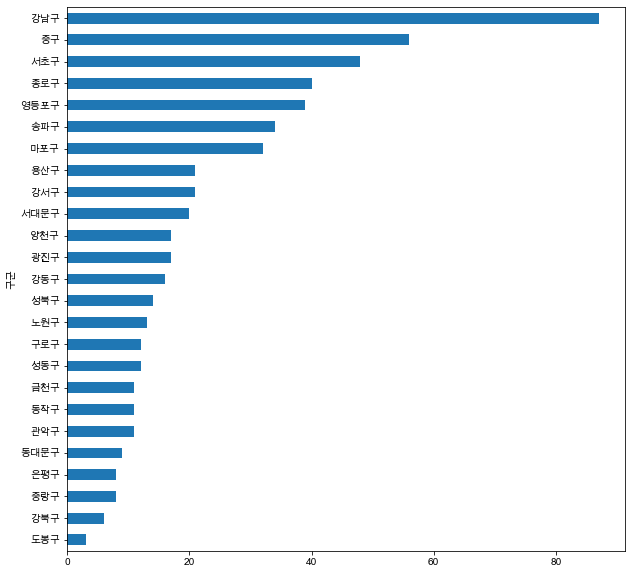

In [164]:
table_result["스타벅스"].sort_values().plot(kind="barh", figsize = (10,10));

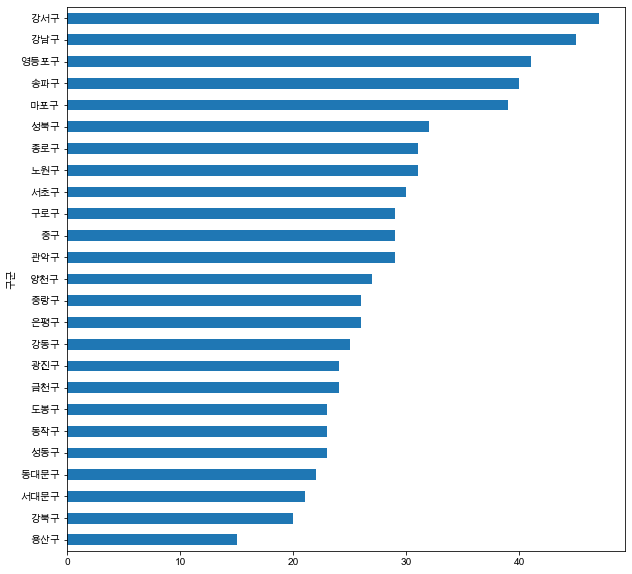

In [165]:
table_result["이디야"].sort_values().plot(kind="barh", figsize = (10,10));

In [245]:
total_raw = pd.concat([df_starbucks, df_ediya])
total_raw["위도"]=total_raw["위도"].astype(float)
total_raw["경도"]=total_raw["경도"].astype(float)
total_raw["회사"]=total_raw["회사"].astype(str)
total_raw.info()
total_raw.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1288 entries, 0 to 721
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   매장명     1288 non-null   object 
 1   주소      1288 non-null   object 
 2   구군      1288 non-null   object 
 3   위도      1288 non-null   float64
 4   경도      1288 non-null   float64
 5   회사      1288 non-null   object 
dtypes: float64(2), object(4)
memory usage: 70.4+ KB


,매장명,주소,구군,위도,경도,회사
0,역삼아레나빌딩,서울특별시 강남구 언주로 425 (역삼동)1522-3232,강남구,37.501087,127.043069,스타벅스
1,논현역사거리,서울특별시 강남구 강남대로 538 (논현동)1522-3232,강남구,37.510178,127.022223,스타벅스
2,신사역성일빌딩,서울특별시 강남구 강남대로 584 (논현동)1522-3232,강남구,37.514132,127.020563,스타벅스
3,국기원사거리,서울특별시 강남구 테헤란로 125 (역삼동)1522-3232,강남구,37.499517,127.031495,스타벅스
4,스탈릿대치R,서울특별시 강남구 남부순환로 2947 (대치동)1522-3232,강남구,37.494668,127.062583,스타벅스


# 2. folium을 이용한 스타벅스와 이디야 분포 현황 비교
 - 실제 지도 내에서 시각적으로 확인하고자 함.
 - 스타벅스의 경우, 강남구, 중구, 서초구 등의 지역에 집중되어 분포 되어 있음.
 - 이디야의 경우, 비교적 골고루 분포 되어 있는 것으로 보임.
 - 스타벅스의 경우, 매장이 많은 지역과 매장이 적은 지역의 격차가 큰 것에 반해, 
 - 이디야의 경우, 매장이 많은 지역과 적은 지역의 격차가 작은 것 뿐만 아니라, 전반적으로 분포되어 있다고 볼 수 있음.

In [248]:
m = folium.Map(location = [37.501087, 127.043069], zoom_start = 12)

for row in total_raw.itertuples():
    popup_name = row.회사
    
    if row.회사 == "이디야":
        icon_color = "blue"
    else:
        icon_color = "green"
        
    folium.features.CircleMarker(
        location = [row.위도, row.경도],
        radius = 5,
        popup = popup_name,
        color = icon_color,
        fill = True,
        fill_color = icon_color
    ).add_to(m)

m

In [260]:
df_ediya2 = df_ediya
df_ediya_distance = []
min_distance = 0.5

for ediya_store in df_ediya2.itertuples():
    distance = 999
    ediya_coord = (float(ediya_store.위도), float(ediya_store.경도))
    
    for startbucks_store in df_starbucks.itertuples():
        starbucks_coord = (float(startbucks_store.위도), float(startbucks_store.경도))
        result_distance = haversine(ediya_coord, starbucks_coord)
        
        if min_distance >= result_distance and distance > result_distance:
            distance = result_distance
    
    df_ediya_distance.append(distance * 1000)

df_ediya2["거리"] = df_ediya_distance
df_ediya2["여부"] = ["N" if dist >= 500 else "Y" for dist in df_ediya['거리']]
df_ediya2

,매장명,주소,구군,위도,경도,회사,거리,여부
0,강남센트럴시티점,"서울 서초구 신반포로 176 (반포동, 센트럴시티)",서초구,37.504281262,127.004566674,이디야,48.283401,Y
1,교대역점,"서울 서초구 서초대로56길 22 (서초동, 성운빌딩)",서초구,37.493484446,127.017109183,이디야,283.804080,Y
2,교육개발원사거리점,"서울 서초구 바우뫼로 180 (양재동, 신송빌딩)",서초구,37.478276774,127.039815579,이디야,472.784159,Y
3,구반포역점,"서울 서초구 신반포로 50 (반포동, 구반포상가)",서초구,37.501785187,126.990140685,이디야,999000.000000,N
4,국립중앙도서관디지털관점,"서울 서초구 반포대로 201 (반포동, 국립중앙도서관)",서초구,37.497888577,127.003767303,이디야,490.479034,Y
...,...,...,...,...,...,...,...,...
717,천호로데오점,서울 강동구 천호대로 1027 (천호동),강동구,37.538235181,127.126149775,이디야,112.793062,Y
718,천호역점,서울 강동구 천호대로 1006 (성내동),강동구,37.538043826,127.123729871,이디야,75.590075,Y
719,천호중앙점,"서울 강동구 올림픽로 660 (천호동, 천호엘크루주상복합)",강동구,37.540177300,127.124560615,이디야,104.207760,Y
720,천호초교사거리점,"서울 강동구 구천면로 304 (천호동, 일주빌딩)",강동구,37.546705315,127.134820700,이디야,999000.000000,N


In [271]:
tmp = pd.pivot_table(
    df_ediya2,
    index=["구군"],
    values=["거리"],
    columns=["여부"],
    aggfunc=len,
    margins=True
)
tmp.head()

거리        
여부    N   Y All
구군             
강남구   5  40  45
강동구   8  17  25
강북구  11   9  20
강서구  13  34  47
관악구  13  16  29

In [275]:
tmp["rate"] = (tmp[("거리", "Y")] / tmp[("거리", "All")]) * 100
tmp.head()

거리               rate
여부    N   Y All           
구군                        
강남구   5  40  45  88.888889
강동구   8  17  25  68.000000
강북구  11   9  20  45.000000
강서구  13  34  47  72.340426
관악구  13  16  29  55.172414

# 3. 이디야 매장을 기준으로 500m 내 스타벅스가 있는 비율을 구별로 확인함
 - 500m 내 스타벅스가 있는 매장의 비율을 살펴보았음.
 - 비율이 높은 지역은 중구, 강남구, 종로구, 송파구, 용산구 순으로 나타남.
 - 비율이 높은 지역은 그만큼 스타벅스의 매장도 많은 지역임.
 - 서울 전체에서의 비중은 66%로 비교적 이디야의 입점 기준이 스타벅스와 유사하다고 보기는 어렵다고 판단됨.

 - [결론] 스타벅스는 유동인구가 많은 곳에 집중되어 있으며, 이디야는 매장별 거리를 유지하며 골고루 퍼져있다고 볼 수 있음.

In [292]:
tmp_sort = tmp.sort_values(by="rate", ascending=False)

def drawGraph():
    plt.figure(figsize=(10, 10))
    sns.heatmap(tmp_sort.loc[:, ["rate"]], annot=True, fmt="f", linewidths=0.5, cmap="RdPu")
    plt.title("이디야는 정말 스타벅스 옆에 있는가?!")
    plt.show()

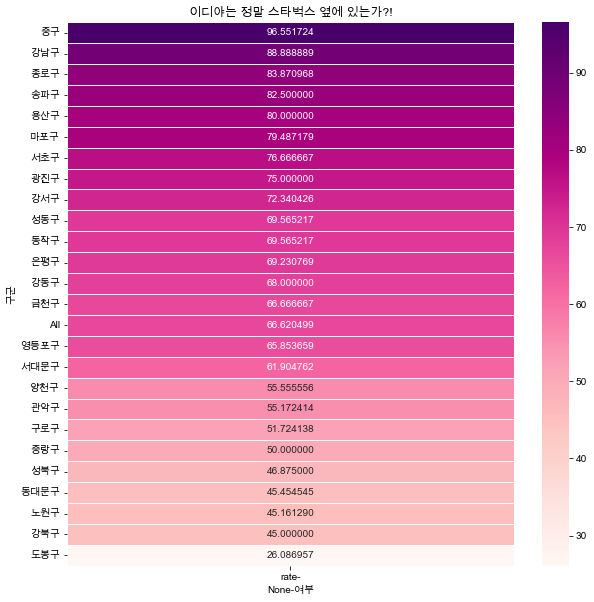

In [293]:
drawGraph()